# RF Impairments

When RF signals travel through the air from a transmitter to a receiver they get affected by a great deal of channel effects which must be dealt with to recover the data. But in order to combat the impairments, we should at least understand what they look like and what causes them.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from comms_helpers import *

In [2]:
def gen_data(num_examples, mod_order=4, sps=8, snr=50):
    
    span=8
    num_weights= sps*span+1
    hrrc = make_rrc(num_weights=num_weights, fs=sps)
    
    ints = np.random.randint(low=0, high=mod_order, size=(num_examples))
    samples = modulate(ints, M=mod_order)
    samples_pulse_shaped = pulse_shape(samples, hrrc, sps=sps)
    samples_noisy = awgn(samples_pulse_shaped, snr)
    
    return samples_noisy

def make_rrc(num_weights=41, alpha=0.35, fs=5):
    Ts =  1/fs
    
    # Calculate time indexes of filter weights
    x = np.arange(-int(num_weights/2),int(num_weights/2),1)/fs
    
    # Preallocate memory for filter weights
    h_rrc = np.zeros(num_weights,)

    # Check for special cases, otherwise apply the main formula
    for idx, weight in enumerate(x):
        if weight == Ts/(4*alpha):
            h_rrc[idx] = (alpha/np.sqrt(2))*(((1+2/np.pi) * (np.sin(np.pi/(4*alpha)))) + ((1-2/np.pi)*(np.cos(np.pi/(4*alpha)))))
        elif weight == -Ts/(4*alpha):
            h_rrc[idx] = (alpha/np.sqrt(2))*(((1+2/np.pi) * (np.sin(np.pi/(4*alpha)))) + ((1-2/np.pi)*(np.cos(np.pi/(4*alpha)))))
        elif weight == 0:
            h_rrc[int(num_weights/2)] = 1/Ts*(1+alpha*(4/np.pi - 1))
        else:
            h_rrc[idx] = 1/Ts*(np.sin(np.pi*weight*(1-alpha)) + 4*alpha*weight*np.cos(np.pi*weight*(1+alpha)))/(np.pi*weight*(1-(4*alpha*weight)**2))
            
    # Normalize the weights
    h_rrc = h_rrc/np.max(h_rrc)
    
    return h_rrc

def pulse_shape(symbols, hrrc, sps=4):
    
    num_weights = len(hrrc)
    
    padded_symbols = np.zeros(len(symbols)*sps, dtype=complex)
    padded_symbols[np.arange(0,len(padded_symbols),sps)] = symbols
    
    # to take care of the transient we append a bunch of zeros
    shaped_symbols = np.convolve(np.concatenate((np.zeros(int((num_weights-1)/2)),padded_symbols)), hrrc, mode='same')
    
    return shaped_symbols[int((num_weights-1)/2):]

# add phase offset in degrees
def phase_offset(x, offset):
    
    # Convert to polar form so we can add degrees
    mag, ang = np.abs(x), np.angle(x, deg=True)
    
    return mag * np.exp( 1j * ((ang + offset)*np.pi/180) )

## Modulation schemes

In [20]:
def plots(symbols, rango=-1):
    fig, ax = plt.subplots(1,2, figsize=(8,2))
    ax[0].plot(symbols.real[:rango])
    ax[0].plot(symbols.imag[:rango])
    ax[1].plot(symbols.real[:rango], symbols.imag[:rango], 'o')

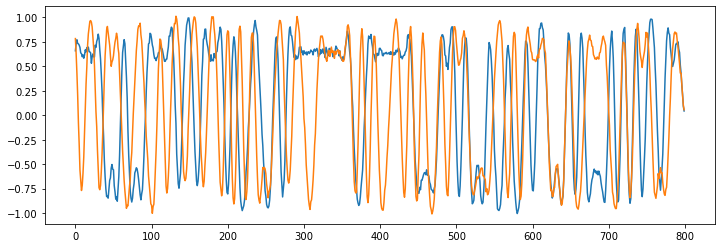

In [79]:
plt.figure(figsize=(12,4))
plt.plot(qpsk_symbols.real)
plt.plot(qpsk_symbols.imag)
plt.savefig('for_drawing.svg')

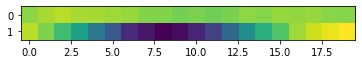

In [83]:
plt.imshow(np.vstack((qpsk_symbols.real[:20],qpsk_symbols.imag[:20])))

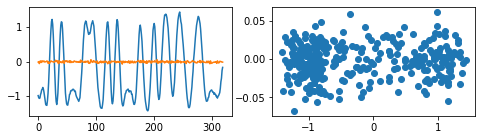

In [25]:
bpsk_symbols = gen_data(40, mod_order=2, sps=8, snr=30)
plots(bpsk_symbols)

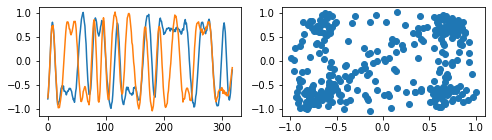

In [26]:
qpsk_symbols = gen_data(40, mod_order=4, sps=8, snr=30)
plots(qpsk_symbols)

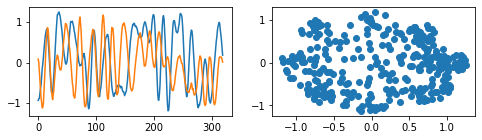

In [27]:
psk8_symbols = gen_data(40, mod_order=8, sps=8, snr=30)
plots(psk8_symbols)

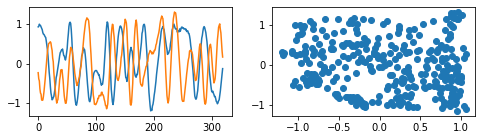

In [28]:
qam16_symbols = gen_data(40, mod_order=16, sps=8, snr=30)
plots(qam16_symbols)

## Higher Order Stats

In [66]:
def calc_moments(x):
    m2 = np.mean((x-np.mean(x))**2) 
    m3 = np.mean((x-np.mean(x))**3)/(np.mean((x-np.mean(x))**2)**(3/2))
    m4 = np.mean((x-np.mean(x))**4)/(np.mean((x-np.mean(x))**2)**(2))-3
    m5 = np.mean((x-np.mean(x))**5)/(np.mean((x-np.mean(x))**2)**(5/2))
    m6 = np.mean((x-np.mean(x))**6)/(np.mean((x-np.mean(x))**2)**(3))
    
    return m2, m3, m4, m5, m6

In [67]:
from scipy.stats import skew, kurtosis

In [68]:
calc_moments(np.abs(psk8_symbols))

(0.06038934546346697,
 -0.9687205976931721,
 0.5965233595874859,
 -7.396642271350191,
 21.898396052598752)

In [60]:
skew(np.abs(bpsk_symbols))

-0.7925416799280638

In [63]:
kurtosis(np.abs(bpsk_symbols), fisher=False)

2.8596205680486033

In [41]:
bpsk_symbols = gen_data(100, mod_order=2, sps=8, snr=30)
qpsk_symbols = gen_data(100, mod_order=4, sps=8, snr=30)
psk8_symbols = gen_data(100, mod_order=8, sps=8, snr=30)
qam16_symbols = gen_data(100, mod_order=16, sps=8, snr=30)

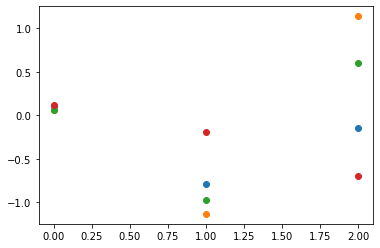

In [72]:
plt.plot(calc_moments(np.abs(bpsk_symbols))[:3], 'o')
plt.plot(calc_moments(np.abs(qpsk_symbols))[:3], 'o')
plt.plot(calc_moments(np.abs(psk8_symbols))[:3], 'o')
plt.plot(calc_moments(np.abs(qam16_symbols))[:3], 'o')

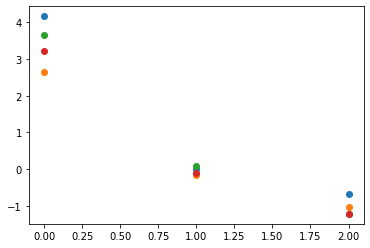

In [74]:
plt.plot(calc_moments(np.angle(bpsk_symbols))[:3], 'o')
plt.plot(calc_moments(np.angle(qpsk_symbols))[:3], 'o')
plt.plot(calc_moments(np.angle(psk8_symbols))[:3], 'o')
plt.plot(calc_moments(np.angle(qam16_symbols))[:3], 'o')

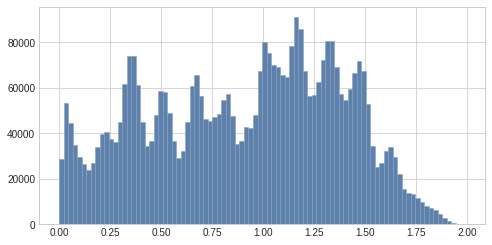

In [4]:
data = np.random.randint(0,2,1000000)
bpsk_symbols = modulate(data, M=2, normalized=True)
rrc = make_rrc(num_weights=65)
bpsk_symbols = pulse_shape(bpsk_symbols, rrc, sps=4)
bpsk_symbols = awgn(bpsk_symbols,30)

plt.figure(figsize=(8,4)) # Make it 14x7 inch
plt.style.use('seaborn-whitegrid') # nice and clean gridplt.hist(x, bins=90, facecolor = '#2ab0ff', edgecolor='#169acf', linewidth=0.5)plt.title('Normal Distribution') 
plt.hist(np.abs(bpsk_symbols), bins=90, facecolor = '#5e81ac', edgecolor='#81a1c1', linewidth=0.5)
# plt.savefig('qam16_abs_hist.png')
plt.show()

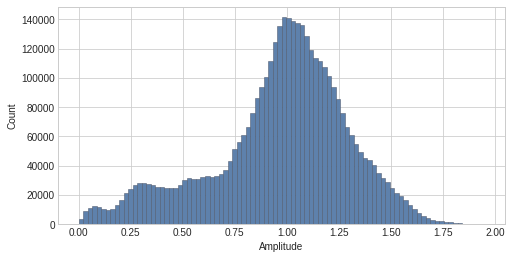

In [16]:
data = np.random.randint(0,4,1000000)
symbols = modulate(data, M=4, normalized=True)
rrc = make_rrc(num_weights=65)
symbols = pulse_shape(symbols, rrc, sps=4)
symbols = awgn(symbols,30)

plt.figure(figsize=(8,4)) # Make it 14x7 inch
plt.style.use('seaborn-whitegrid') # nice and clean gridplt.hist(x, bins=90, facecolor = '#2ab0ff', edgecolor='#169acf', linewidth=0.5)plt.title('Normal Distribution') 
plt.hist(np.abs(symbols), bins=90, facecolor = '#5e81ac', edgecolor='#4c566a', linewidth=0.5)
plt.xlabel('Amplitude') 
plt.ylabel('Count') 
plt.savefig('figures/qpsk_abs_hist.png', dpi=300, bbox_inches='tight')

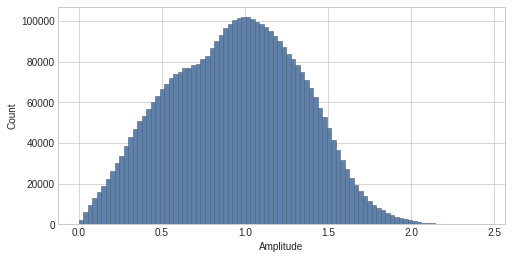

In [17]:
data = np.random.randint(0,16,1000000)
qam16_symbols = modulate(data, M=16, normalized=True)
rrc = make_rrc(num_weights=65)
qam16_symbols = pulse_shape(qam16_symbols, rrc, sps=4)
qam16_symbols = awgn(qam16_symbols,30)

plt.figure(figsize=(8,4)) # Make it 14x7 inch
plt.style.use('seaborn-whitegrid') # nice and clean gridplt.hist(x, bins=90, facecolor = '#2ab0ff', edgecolor='#169acf', linewidth=0.5)plt.title('Normal Distribution') 
plt.hist(np.abs(qam16_symbols), bins=90, facecolor = '#5e81ac', edgecolor='#4c566a', linewidth=0.5)
plt.xlabel('Amplitude') 
plt.ylabel('Count') 
plt.savefig('figures/qam16_abs_hist.png', dpi=300, bbox_inches='tight')

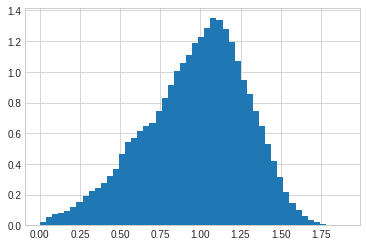

In [7]:
data = np.random.randint(0,8,1000000)
qam_symbols = modulate(data, M=8, normalized=True)
rrc = make_rrc()
qam_symbols = pulse_shape(qam_symbols, rrc, sps=4)
qam_symbols = awgn(qam_symbols,30)

plt.hist(np.abs(qam_symbols), density=True, histtype='bar',bins=50)
plt.show()

In [ ]:
# feature_vec(:,1) = mean(data .* conj(data)); %/ sqrt( mean( (data - mean(data)) .* conj(data - mean(data)) ) ); % C21
# feature_vec(:,2) = mean(data .* conj(data)) / sqrt( mean( (data - mean(data)) .* conj(data - mean(data)) ) ); % C21 standardized
# feature_vec(:,3) = abs((mean(data.^4) - 3*mean(data.^2)^2) / feature_vec(:,1)^2); % C40
# feature_vec(:,4) = abs((mean(data.^3 .* conj(data)) - 3*mean(data.^2)*mean(abs(data).^2)) / feature_vec(:,1)^2); % C41
# feature_vec(:,5) = (mean(abs(data).^4) - abs(mean(data.^2))^2 - 2*mean(abs(data).^2)^2) / feature_vec(:,1)^2; % C42
# feature_vec(:,6) = (mean(abs(data).^6) - 9*mean(abs(data).^4)*mean(abs(data).^2) + 12*abs(mean(data.^2))^2 * mean(abs(data).^2) + 12 * mean(abs(data).^2)^3) / feature_vec(:,1)^3; % C63

In [35]:
def calc_cumulants(x):
    c21 = np.mean(x * np.conj(x))
    c21_s = c21 / np.sqrt(np.mean((x - np.mean(x)) * np.conj(x - np.mean(x))))
    c40 = np.abs((np.mean(x**4) - 3*np.mean(x**2)**2) / c21**2)
    c41 = np.abs((np.mean(x**3 * np.conj(x)) - 3*np.mean(x**2)*np.mean(np.abs(x)**2)) / c21**2)
    c42 = (np.mean(np.abs(x)**4) - np.abs(np.mean(x**2))**2 - 2*np.mean(np.abs(x)**2)**2) / c21**2
    c63 = (np.mean(np.abs(x)**6) - 9*np.mean(np.abs(x)**4)*np.mean(np.abs(x)**2) + 12*np.abs(np.mean(x**2))**2 * np.mean(np.abs(x)**2) + 12 * np.mean(np.abs(x)**2)**3) / c21**3
    return c21, c21_s, c40, c41, c42, c63

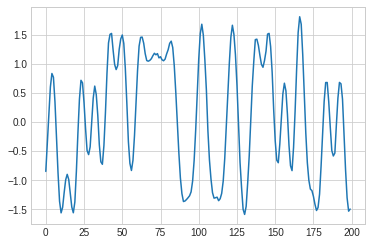

In [52]:
plt.plot(bpsk_symbols.real[:200])

In [45]:
calc_cumulants(np.angle(bpsk_symbols))

(4.808144967227724,
 2.1927483926775597,
 0.9988328132172286,
 0.9988328132172286,
 -0.9988328132172288,
 10.012235793587928)

In [46]:
calc_cumulants(np.angle(symbols))

(3.219226755011951,
 1.7942215108279023,
 1.2529911235450975,
 1.2529911235450977,
 -1.2529911235450975,
 11.835049149371654)

In [47]:
calc_cumulants(np.angle(qam16_symbols))

(3.266780477811393,
 1.8074238051949494,
 1.2161529323469957,
 1.2161529323469957,
 -1.2161529323469957,
 11.71167803420003)

In [48]:
calc_cumulants(np.angle(qam_symbols))

(3.290276767647229,
 1.813912406004954,
 1.198404790797364,
 1.1984047907973647,
 -1.1984047907973643,
 11.653255762900622)

In [30]:
def calc_moments(x):
    m2 = np.mean((x-np.mean(x))**2) 
    m3 = np.mean((x-np.mean(x))**3)/(np.mean((x-np.mean(x))**2)**(3/2))
    m4 = np.mean((x-np.mean(x))**4)/(np.mean((x-np.mean(x))**2)**(2))
    m5 = np.mean((x-np.mean(x))**5)/(np.mean((x-np.mean(x))**2)**(5/2))
    m6 = np.mean((x-np.mean(x))**6)/(np.mean((x-np.mean(x))**2)**(3))
    
    return m2, m3, m4, m5, m6

In [9]:
print(calc_moments(np.abs(bpsk_symbols)))
print(calc_moments(np.angle(bpsk_symbols)))

(0.2158380860013234, -0.17093883351924347, 1.9729747294202473, -0.6202391514960544, 5.003143901233119)
(4.8081444208654895, 0.0002761748379358037, 2.001167332170735, 0.0018570701896496035, 4.022742191055829)


In [14]:
print(calc_moments(np.abs(symbols)))
print(calc_moments(np.angle(symbols)))

(0.109343140246065, -0.6070849054231342, 3.1903770099241786, -3.99564508308623, 14.79436817382764)
(3.2192226801114994, 0.0011424851163342874, 1.7470108459209848, 0.00524651507573102, 3.5581447950566987)


In [11]:
print(calc_moments(np.abs(qam16_symbols)))
print(calc_moments(np.angle(qam16_symbols)))

(0.15555561454932249, -0.004220090175039619, 2.4057682021480535, 0.32939918037675897, 8.379447867078673)
(3.2667801440374293, -0.0003979859027255689, 1.7838473279939773, -0.0016394744255952783, 3.7663032079048295)


In [12]:
print(calc_moments(np.abs(qam_symbols)))
print(calc_moments(np.angle(qam_symbols)))

(0.10118298799892093, -0.40765564865371107, 2.788535613648688, -2.792048167909077, 11.96508451556104)
(3.2902753186364144, -0.0008627785895956935, 1.8015964438968182, -0.004248507981279441, 3.8676227707743993)


In [10]:
calc_moments(qam16_symbols)

(0.1555124247230443, -0.006525680768866656, 2.404864855827939)

In [45]:
np.mean((qam16_symbols-np.mean(qam16_symbols))**4)/(np.mean((qam16_symbols-np.mean(qam16_symbols))**2)**(2))

2.4020864436616143

In [46]:
np.mean((symbols-np.mean(symbols))**4)/(np.mean((symbols-np.mean(symbols))**2)**(2))

3.1989116998840172

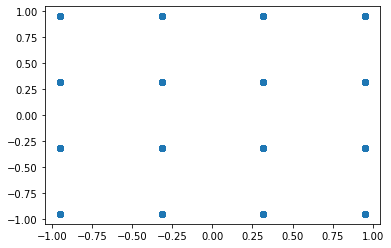

In [16]:
plt.plot(qam16_symbols.real, qam16_symbols.imag, 'o')